# Case Study: Predict if the client will subscribe to a term product

November 2022 <br>
Fatih Catpinar

The aim of the project is to review the dataset, explore it and use machine learning and visualizations to help the marketing team to predict if the client will subscribe to a term product. This prediction model will help marketing to better customers for campaigns to increase sales.

#### Attribute Information:

Input variables: <br>
data that is specific to each client: <br>
1 - age: numeric <br>
2 - job: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') <br>
3 - marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) <br> 
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') <br>
5 - default: has credit in default? (categorical: 'no','yes','unknown') <br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown') <br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown') <br>

related with the last contact of the current campaign: <br>
8 - contact: contact communication type (categorical: 'cellular','telephone') <br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') <br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri') <br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
Data that is not client specific: <br>
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br> 
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) <br>
14 - previous: number of contacts performed before this campaign and for this client (numeric) <br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') <br>

social and economic context attributes: <br>
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric) <br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric) <br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) <br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric) <br>
20 - nr.employed: number of employees - quarterly indicator (numeric) <br>

Output variable (desired target): <br>
21 - y: has the client subscribed a term deposit? (binary: 'yes','no')

## Table of contents
1. [Explore and clean the data](#explore) <br>
    1.1. [Handle duplicates](#1.1) <br>
    1.2. [Check for duplicated columns](#1.2) <br>
    1.3. [Check missing values](#1.3) <br>
    1.4. [Explore target variable](#1.4) <br>
    1.5. [Explore features](#1.5) <br>
2. [Process the data](#process) <br>
    2.1 [Handle missing values for cons.price.idx](#2.1) <br>
    2.2 [One hot encode categorical data](#2.2) <br>
    2.3 [Drop 'duration' column](#2.3) <br>
    2.4 [Change 'pdays' columns to 1 and 0](#2.4) <br>
    2.5 [Dummy code y column](#2.5) <br>
    2.6 [Split the data](#2.6) <br>
    2.7 [Handle unbalanced data](#2.7) <br>
3. [Create models](#model) <br>
    3.1 [Logistic Regression](#3.1) <br>
    3.2 [Random Forest](#3.2) <br>
4. [Conclusion](#conclusion) <br>

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

## 1. Explore and clean the data <a name="explore"></a>

The first step is going to be to load the data and explore. Before we do more analyses and create classification models, we need to understand the data and make sure there is no incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset. We will check if the data has duplicate information, or has any missing values.

In [2]:
df = pd.read_csv('Case Study Data.csv')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no


In [4]:
df.shape

(41188, 21)

There are 41188 rows. Every row is a phone call to client. And there are 21 columns. The last column is y, the output variable. There might be cases where the same client was contacted multiple times.

In [5]:
df.keys()

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### 1.1 Handle duplicates <a name="1.1"></a>

In [6]:
# Check if there are any duplicates
df.duplicated().sum()

9

There are 9 duplicated rows. We need to drop the duplicates since they might give you an inflated results while analysing the data.

In [7]:
# Drop the duplicates
df = df.drop_duplicates()

In [8]:
df.duplicated().sum()

0

In [9]:
df.shape

(41179, 21)

### 1.2 Check for duplicated columns <a name="1.2"></a>

In [10]:
# Check duplicated columns
df.T.duplicated()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

There are no duplicated columns.

### 1.3 Check missing values<a name="1.3"></a>

Missing values can cause bias in the machine learning models and reduce the accuracy of the model. We need to handle the missing values to be able to create an healty classification model.

In [11]:
# Check if there are any null values
df.isna().sum()

age               3744
job                  0
marital              0
education            0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx    5148
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [12]:
# Percentage of the null values
print(df['age'].isna().sum() / df.shape[0] * 100)
print(df['cons.price.idx'].isna().sum() / df.shape[0] * 100)

9.092012919206391
12.501517763908787


There are 3744 missing 'age' which is 9.09% of the data and 5148 missing 'cons.price.idx' (consumer price index) which is 12.5% of the data. We need to handle missing values individually. It will be handled in the next section.

Note that there are also values that are entered as 'unknown' which is also missing values.

In [13]:
df.isin(['unknown']).sum(axis=0)

age                  0
job                330
marital             80
education         1730
default           8596
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [14]:
# Percentage of the unknown values
print(df['job'].isin(['unknown']).sum(axis=0) / df.shape[0] * 100)
print(df['marital'].isin(['unknown']).sum(axis=0) / df.shape[0] * 100)
print(df['education'].isin(['unknown']).sum(axis=0) / df.shape[0] * 100)
print(df['default'].isin(['unknown']).sum(axis=0) / df.shape[0] * 100)
print(df['housing'].isin(['unknown']).sum(axis=0) / df.shape[0] * 100)
print(df['loan'].isin(['unknown']).sum(axis=0) / df.shape[0] * 100)

0.801379343840307
0.1942737803249229
4.201170499526458
20.874717695912963
2.4041380315209206
2.4041380315209206


The unknown values for each variable
- 330 'job' which is 0.8% of the data.
- 80 'marital' which is 0.19% of the data.
- 1730 'education' which is 4.2% of the data.
- 8596 'default' which is 20.8% of the data.
- 990 'housing' which is 2.4% of the data.
- 990 'loan' which is 2.4% of the data.

As seen the most missing variable is 'default' variable. Which is the answer to the question "has credit in default?". Note that a default occurs when a borrower stops making the required payments on a debt. 

In [15]:
df['default'].value_counts()

no         32580
unknown     8596
yes            3
Name: default, dtype: int64

In [16]:
df[(df['housing']=='no') & (df['loan']=='no')]['default'].value_counts()

no         12600
unknown     3456
yes            2
Name: default, dtype: int64

I wanted to check that if 'unknown' in default variable means this person never get a housing or personal loan. But the results sholws that it is not the case. I decided to keep the the unknown answer as is. It might hold some information for the model. We can revisit it later.

In [17]:
df[(df['housing']=='unknown') & (df['loan']=='unknown')].shape

(990, 21)

There are 990 unknowns for both housing loan and personal loan questions. The case number when both of them are unknown at the same time is also 990. It means that the loan questions are not asked at this calls.

We will keep the unknown answers as is in the categorical questions for now. But we should keep in mind that there are unknown values as shown in the previous celss.

There is no duplicated column.

### 1.4 Explore target variable <a name="1.4"></a>

The target variable is y which is the answer to the question "has the client subscribed a term deposit?" there are two possibel answers.

In [18]:
df['y'].describe()

count     41179
unique        2
top          no
freq      36540
Name: y, dtype: object

In [19]:
df['y'].value_counts()

no     36540
yes     4639
Name: y, dtype: int64

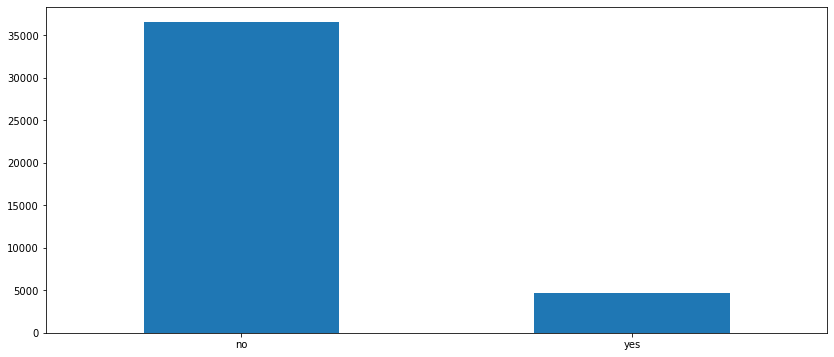

In [20]:
df['y'].value_counts().plot(kind="bar", figsize=(14, 6))
plt.xticks(rotation=0);

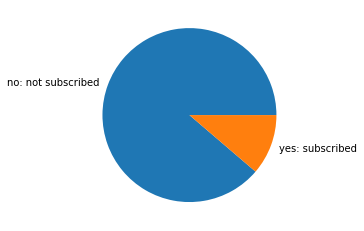

In [21]:
y = df['y'].value_counts()
mylabels = ["no: not subscribed", "yes: subscribed"]

plt.pie(y, labels = mylabels)
plt.show() 

This data set is very unbalanced. Before applying any machine learning algoritm, we need to come with an idea to mitigate the impact of a small number of observed failures.

### 1.5 Explore features <a name="1.5"></a>

#### Age

In [22]:
df['age'].describe()

count    37435.000000
mean        39.999279
std         10.414284
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: age, dtype: float64

The minimum age is 17 and maximum age is 98. The mean is 40.

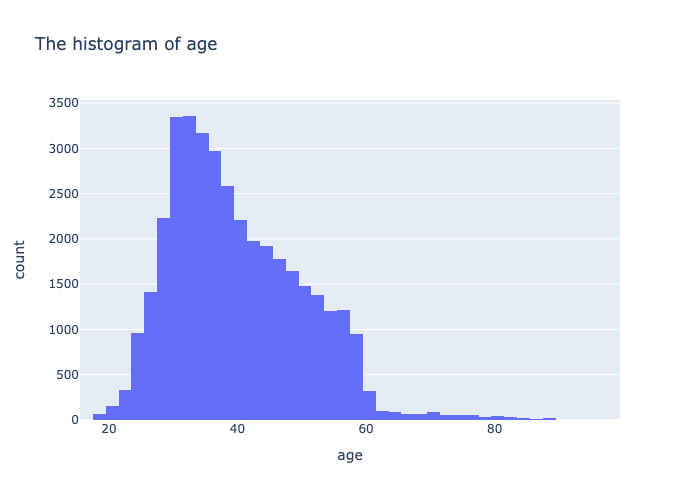

In [23]:
fig = px.histogram(df, x="age", nbins=50, title= "The histogram of age")
fig.show("png")

#### handle the mssing value in age

From the previous section we learned that there are 3744 missing 'age' which is 9.09% of the data. I am planning to fill the with the mean age of group by two variables: job and marital status. I thought it will be more realistic and close to true age values. For example if a person is retired, the age mean is different than if the person is student. And also marital status might have a relation with age.

Note that job categories are: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown' and
marital status categories are 'divorced','married','single','unknown'.

In [24]:
df['age'].isna().sum()

3744

In [25]:
df['age'].fillna(df.groupby(['job','marital'])['age'].transform('mean'), inplace=True)

In [26]:
df['age'].isna().sum()

0

#### Job

In [27]:
df['job'].value_counts()

admin.           10420
blue-collar       9253
technician        6740
services          3968
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [28]:
df['job'].nunique()

12

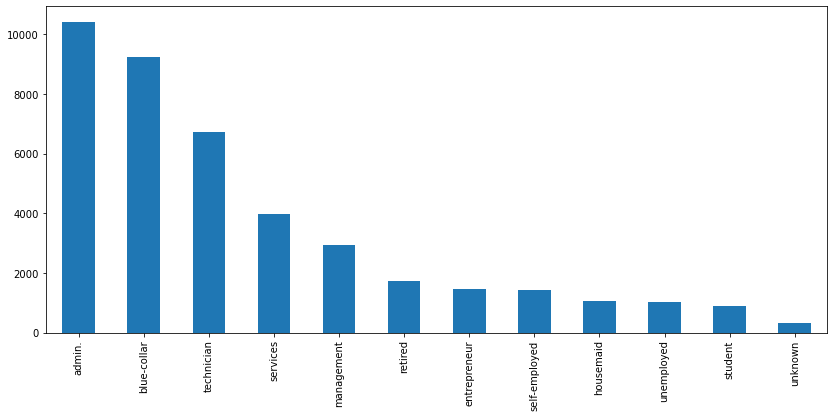

In [29]:
df['job'].value_counts().plot(kind="bar", figsize=(14, 6))
plt.xticks(rotation=90);

#### Marital

In [30]:
df['marital'].value_counts()

married     24922
single      11565
divorced     4612
unknown        80
Name: marital, dtype: int64

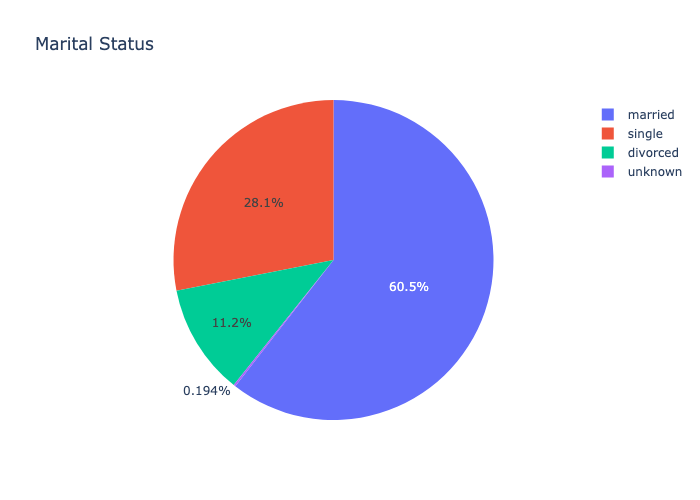

In [31]:
fig = px.pie(values = df['marital'].value_counts(), 
             names = (df['marital'].value_counts()).index, 
             title = 'Marital Status')
fig.show("png")

#### Education

In [32]:
df['education'].value_counts()

university.degree      12165
high.school             9514
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: education, dtype: int64

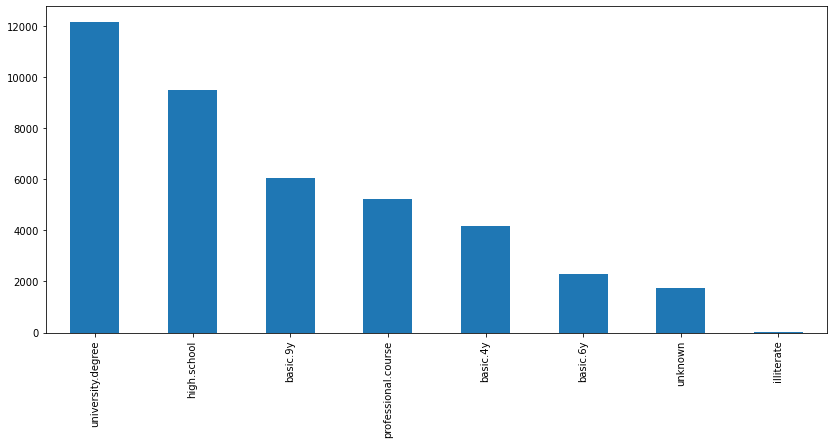

In [33]:
df['education'].value_counts().plot(kind="bar", figsize=(14, 6))
plt.xticks(rotation=90);

#### default

In [34]:
df['default'].value_counts()

no         32580
unknown     8596
yes            3
Name: default, dtype: int64

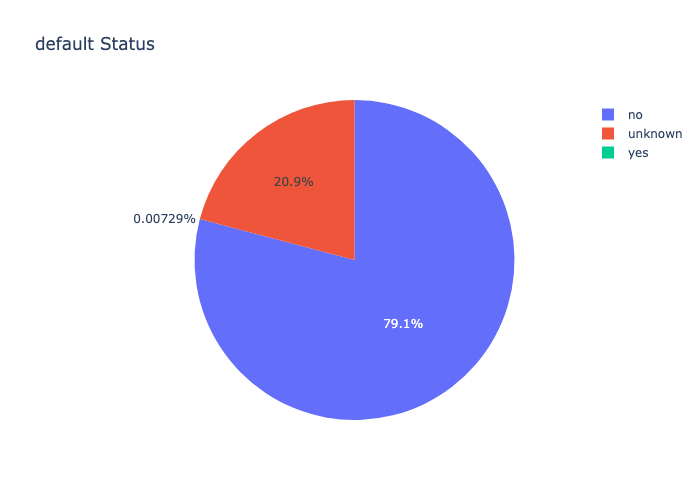

In [35]:
fig = px.pie(values = df['default'].value_counts(), 
             names = (df['default'].value_counts()).index, 
             title = 'default Status')
fig.show("png")

#### pdays

pdays means number of days that passed by after the client was last contacted from a previous campaign. 999 means client was not previously contacted.

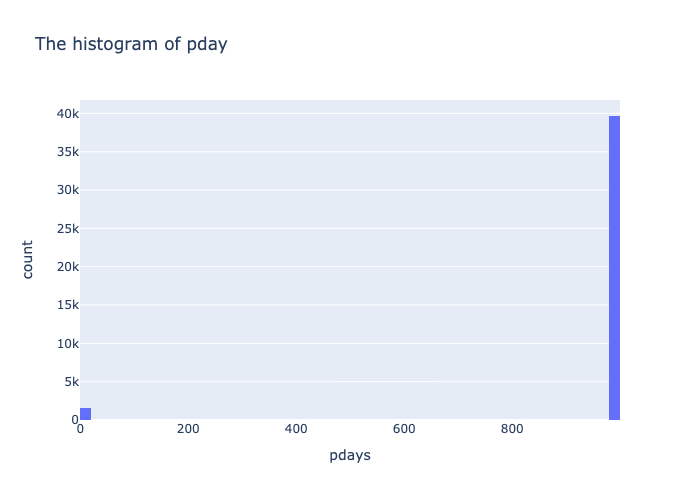

In [36]:
fig = px.histogram(df, x="pdays", nbins=50, title= "The histogram of pday")
fig.show("png")

As seen above most of the values are 999, means the customer was not previoustly contacted. We can change the variable as previously contacted or not in the next section.

## 2. Process the data <a name="process"></a>

- From the previous section we discussed the null valusies. There were two columns with null values: age and cons.price.idx. We have already handled the age and we need to handle cons.price.idx missing values.

- We are planning to apply logistic regression and random forest algorithms. 
Decision tree based algorithms can learn directly from categorical data with no data transform required, logistic regression.
algorithm cannot operate on label data directly. 
This means that categorical data must be converted to a numerical form.

- We need to drop duration because this attribute highly affects the output target (e.g., if duration=0 then y='no'). it should be discarded if the intention is to have a realistic predictive model.

- Also we will change the pday to 1 and 0 where they mean privously contacted and privously not contacted.

- Dummy code y column as 1 and 0.

- Split train test.

- Handle unbalanced train data.

No need to standardize the data.

### 2.1 Handle missing values for cons.price.idx <a name="2.1"></a>

In [37]:
df['cons.price.idx'].describe()

count    36031.000000
mean        93.575615
std          0.579210
min         92.201000
25%         93.075000
50%         93.749000
75%         93.994000
max         94.767000
Name: cons.price.idx, dtype: float64

We can fill it with the mean value since the values are very close to each other.

In [38]:
df['cons.price.idx'] =  df['cons.price.idx'].fillna(df['cons.price.idx'].mean())

In [39]:
df['cons.price.idx'].isna().sum()

0

### 2.2 One hot encode categorical data <a name="2.2"></a>

In [40]:
df_one_hot_encoded = pd.get_dummies(df, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'])

In [41]:
df_one_hot_encoded.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'mon

### 2.3 Drop 'duration' column <a name="2.3"></a>

This attribute highly affects the output target (e.g., if duration=0 then y='no'). it should be discarded if the intention is to have a realistic predictive model.

In [42]:
df_one_hot_encoded.drop(columns=['duration'])

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56.0,1,999,0,1.1,93.994000,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
1,57.0,1,999,0,1.1,93.994000,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
2,37.0,1,999,0,1.1,93.575615,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
3,40.0,1,999,0,1.1,93.994000,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
4,56.0,1,999,0,1.1,93.575615,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73.0,1,999,0,-1.1,94.767000,-50.8,1.028,4963.6,yes,...,0,0,1,0,0,0,0,0,1,0
41184,46.0,1,999,0,-1.1,94.767000,-50.8,1.028,4963.6,no,...,0,0,1,0,0,0,0,0,1,0
41185,56.0,2,999,0,-1.1,93.575615,-50.8,1.028,4963.6,no,...,0,0,1,0,0,0,0,0,1,0
41186,44.0,1,999,0,-1.1,94.767000,-50.8,1.028,4963.6,yes,...,0,0,1,0,0,0,0,0,1,0


### 2.4 Change 'pdays' columns to 1 and 0 <a name="2.4"></a>

As discussed before; 999 means the customer was not previoustly contacted. pdays gives number of days that passed by after the client was last contacted from a previous campaign. We will change the pday to 1 and 0 where they mean privously contacted and privously not contacted.

In [43]:
df_one_hot_encoded['pdays']

0        999
1        999
2        999
3        999
4        999
        ... 
41183    999
41184    999
41185    999
41186    999
41187    999
Name: pdays, Length: 41179, dtype: int64

In [44]:
df_one_hot_encoded['pdays'] = df_one_hot_encoded['pdays'].apply(lambda x: 1 if x<999 else 0)

In [45]:
df_one_hot_encoded['pdays'].value_counts()

0    39664
1     1515
Name: pdays, dtype: int64

### 2.5 Dummy code y column <a name="2.5"></a>

In [46]:
df_one_hot_encoded['y'] = df_one_hot_encoded['y'].apply(lambda x: 1 if x=='yes' else 0)

In [47]:
df_one_hot_encoded['y'].value_counts()

0    36540
1     4639
Name: y, dtype: int64

### 2.6 Split the data <a name="2.6"></a>

In [48]:
# Create X and Y numpy arrays from randomized data 
x = np.array(df_one_hot_encoded.loc[:, df_one_hot_encoded.columns != 'y'])
y = np.array(df_one_hot_encoded['y'])

%80 for training and %20 for testing

In [49]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

### 2.7 Handle unbalanced data <a name="2.7"></a>

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In [50]:
# SMOTE train data

os = SMOTE(random_state=0)
x_train, y_train = os.fit_sample(x_train, y_train)

print(x_train.shape)

(58464, 63)


In [51]:
len(y_train[y_train == 0])

29232

In [52]:
len(y_train[y_train == 1])

29232

In [53]:
len(y_train)

58464

After SMOTE we have equal number of 0 and 1 labels.

## 3. Create Models <a name="model"></a>

We have a classification problem. We are trying to classify the subscriptions.

### 3.1 Logistic Regression <a name="3.1"></a>

Logistic regression is a classification algorithm used to find the probability of event success and event failure.
Logistic regression is easier to implement, interpret, and very efficient to train.

In [54]:
clf = LogisticRegression(random_state=0, max_iter=10000).fit(x_train, y_train)
y_pred = clf.predict(x_test)

The logistic regression calculates the probabilties of the each class. We tuned the trashold that makes the prediction based on the probabilies.

In [55]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[6244, 1064],
       [ 112,  816]])

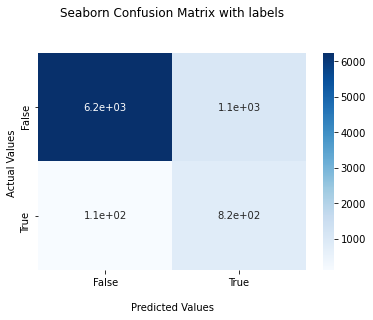

In [56]:

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [57]:
len(y_test[y_test == 0])

7308

In [58]:
len(y_test[y_test == 1])

928

In [59]:
TP = sum(y_pred + y_test == 2) # it is 1, prediction says 1
FP = sum(y_pred - y_test == 1) # it is 0, prediction says 1
TN = sum(y_pred + y_test == 0) # it is 0, prediction says 0
FN = sum(y_pred - y_test == -1) # it is 1, prediction says 0

print("\nResults Summary:\n")
print("True Positive:", TP)
print("False Positive:", FP)
print("True Negative:", TN)
print("False Negative:", FN)

accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2*precision*recall) / (precision + recall)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("Accuracy:", accuracy)


Results Summary:

True Positive: 816
False Positive: 1064
True Negative: 6244
False Negative: 112

Precision: 0.4340425531914894
Recall: 0.8793103448275862
F1: 0.5811965811965811
Accuracy: 0.8572122389509471


ROC AUC for Model: Logistic Regression


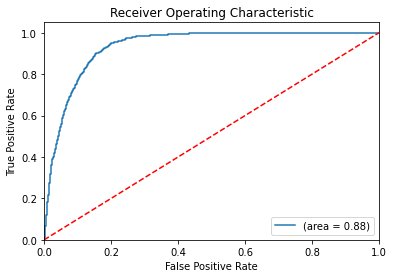

In [60]:
roc_auc = roc_auc_score(y_train, clf.predict(x_train))
print('ROC AUC for Model: Logistic Regression')
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label= '(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('_ROC_')
plt.show()

Logistic regression model is created.
The accuracy of the model is 0.86. The precision is 0.44 and Recall is 0.88.

There were total 928 subscriptions and 7310 non-subscriptions in the test data. 
820 of the subscriptions are detected with the designed model.
We have 1043 false positives. It means there was no subscription but the model detect it as subscription.

### 3.2 Random forest <a name="3.2"></a>

In [61]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(x_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(x_test)

In [62]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[7073,  235],
       [ 503,  425]])

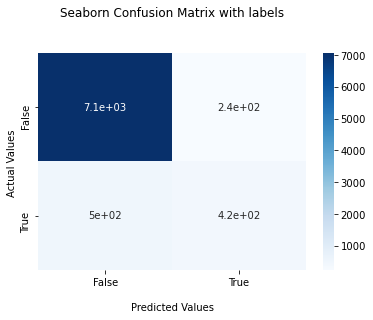

In [63]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [64]:
TP = sum(y_pred + y_test == 2) # it is 1, prediction says 1
FP = sum(y_pred - y_test == 1) # it is 0, prediction says 1
TN = sum(y_pred + y_test == 0) # it is 0, prediction says 0
FN = sum(y_pred - y_test == -1) # it is 1, prediction says 0

print("\nResults Summary:\n")
print("True Positive:", TP)
print("False Positive:", FP)
print("True Negative:", TN)
print("False Negative:", FN)

accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2*precision*recall) / (precision + recall)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("Accuracy:", accuracy)


Results Summary:

True Positive: 425
False Positive: 235
True Negative: 7073
False Negative: 503

Precision: 0.6439393939393939
Recall: 0.4579741379310345
F1: 0.535264483627204
Accuracy: 0.9103933948518699


Random Forest model is created. The accuracy of the model is 0.9. The precision is 0.63 and Recall is 0.46.

There were total 928 subscriptions and 7310 non-subscriptions in the test data. 427 of the subscriptions are detected with the designed model. We have 241 false positives. 

The false positive case is lower than the logistic regression.

ROC AUC for Model: Random Forest


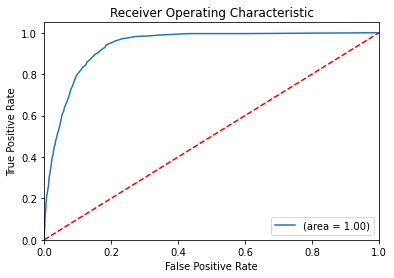

In [65]:
roc_auc = roc_auc_score(y_train, clf.predict(x_train))
print('ROC AUC for Model: Random Forest')
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label= '(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('_ROC_')
plt.show()

## 4. Conclusion <a name="conclusion"></a>

### Model Evaluation


Logistic regression model is created.
The accuracy of the model is 0.86. The precision is 0.44 and Recall is 0.88.

There were total 928 subscriptions and 7310 non-subscriptions in the test data. 
820 of the subscriptions are detected with the designed model.
We have 1043 false positives. It means there was no subscription but the model detect it as subscription.

Random Forest model is created. The accuracy of the model is 0.9. The precision is 0.63 and Recall is 0.46.

There were total 928 subscriptions and 7310 non-subscriptions in the test data. 427 of the subscriptions are detected with the designed model. We have 241 false positives. 

Random Forest's false positive case is lower than the logistic regression.

Based on the needs both model can be used. I would choose Random forest since it has higher precision.

### Use cases

Predicting time to call and adjusting marketing plans benefits both banks and their customers. It improves the efficiency of the bank's telemarketing campaigns, saving time and effort. It prevents some customers from receiving unwanted advertisements and improves customer satisfaction.


### List of possible additional data that can help the model accuracy

- Credit Score of the customer.
- Checking or saving balance of the customer.
- The information of usage of any automatric payment method.
- The information of usage online banking. 
- If online banking is active, the frequency of usage, and the tools the customer uses the most. 
- The location of the customer.